In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import numpy as np
import torch
import matplotlib.pyplot as plt

# **Import data from google drive**

d_{networkname} = the average distance accross layers computed by the network

d_{networkname}_ret = values of the L2 distance from each layers of the network

target = labels for each tiral, (1:right image is prefered, 0:left image is prefered)

In [ ]:
d_vgg=np.load(r'/content/drive/MyDrive/Personalized Perception/LPIPS Experiment /Data/d_vgg.npy',allow_pickle=True)
d_vgg_ret=np.load(r'/content/drive/MyDrive/Personalized Perception/LPIPS Experiment /Data/d_vgg_ret.npy',allow_pickle=True)
target=np.load(r'/content/drive/MyDrive/Personalized Perception/LPIPS Experiment /Data/target_data_Eddy_random.npy')

In [ ]:
d_vgg_ret_clean=[]
for data in d_vgg_ret:
  a=[]
  for i in data:
    a.append(i[0,0,0,0].item())
  d_vgg_ret_clean.append(a)

In [ ]:
d_vgg_ret_clean=np.array(d_vgg_ret_clean)
target=np.array(target)

Here we check the quantities of each classes.

We can see Eddy's behavior data is slightly class imbalance.

In [ ]:
print(np.count_nonzero(target ==1))
print(np.count_nonzero(target ==0))

533
467


Here I plot the tSNE plotting in order to observe the distribution of the dataset.

In [ ]:
from sklearn.manifold import TSNE
tsne = TSNE(n_components=2, random_state=0, perplexity=50, init='pca', learning_rate='auto') #perplexityfloat, default=30.0

In [ ]:
left_selection_data=[]
right_selection_data=[]
for data, label in zip(d_vgg_ret_clean,target):
  if label == 1:
    right_selection_data.append(data)
  else:
    left_selection_data.append(data)
left_selection_data=np.array(left_selection_data)
right_selection_data=np.array(right_selection_data)

In [ ]:
left_selection_data_2d=np.array(tsne.fit_transform(left_selection_data))
right_selection_data=np.array(tsne.fit_transform(right_selection_data))

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:986: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:986: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  FutureWarning,


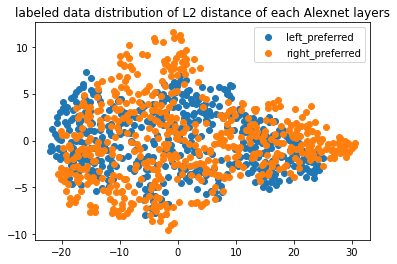

In [ ]:
plt.title(r'labeled data distribution of L2 distance of each Alexnet layers')
plt.scatter(left_selection_data_2d[:,0],left_selection_data_2d[:,1],label='left_preferred')
plt.scatter(right_selection_data[:,0],right_selection_data[:,1],label='right_preferred')
plt.legend()
plt.show()

The data is unseperable and slightly imbalance between two classes.

The following step, I train several machine learning models with L2 distance data extracted from each layers. For estimation, I implement cross validation in order to obtain complete testing over the dataset.

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import make_moons, make_circles, make_classification
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn import metrics 
from sklearn.model_selection import cross_val_score

In [ ]:
classifiers = [
    KNeighborsClassifier(3),
    SVC(kernel="linear", C=0.025),
    SVC(),
    GaussianProcessClassifier(1.0 * RBF(1.0)),
    DecisionTreeClassifier(max_depth=5),
    RandomForestClassifier(max_depth=5, n_estimators=10, max_features=1),
    MLPClassifier(alpha=1, max_iter=1000),
    AdaBoostClassifier(),
    GaussianNB(),
    QuadraticDiscriminantAnalysis()]

In [ ]:
variables_name= ['Classifier','Accuracy','Auc','Percision','Recall','G-mean','F1-measure']
report={variable:[] for variable in variables_name}

In [ ]:
#setup g_mean score
from sklearn.metrics import make_scorer
from imblearn.metrics import geometric_mean_score

gm_scorer = make_scorer(geometric_mean_score, greater_is_better=True)

In [ ]:
for clf in classifiers:
  report['Classifier'].append(clf)
  acc_score=cross_val_score(clf, d_vgg_ret_clean, target, cv=10)
  report['Accuracy'].append("%0.2f (+/- %0.2f)" % (acc_score.mean(), acc_score.std() ** 2))
  auc_score=cross_val_score(clf, d_vgg_ret_clean, target, cv=10, scoring='roc_auc')
  report['Auc'].append("%0.2f (+/- %0.2f)" % (auc_score.mean(), auc_score.std() ** 2))
  percision_score=cross_val_score(clf, d_vgg_ret_clean, target, cv=10, scoring='precision')
  report['Percision'].append("%0.2f (+/- %0.2f)" % (percision_score.mean(), percision_score.std() ** 2))
  recall_score=cross_val_score(clf, d_vgg_ret_clean, target, cv=10, scoring='recall')
  report['Recall'].append("%0.2f (+/- %0.2f)" % (recall_score.mean(), recall_score.std() ** 2))
  g_mean_score=cross_val_score(clf, d_vgg_ret_clean, target, cv=10, scoring=gm_scorer)
  report['G-mean'].append("%0.2f (+/- %0.2f)" % (g_mean_score.mean(), g_mean_score.std() ** 2))
  F1_score=cross_val_score(clf, d_vgg_ret_clean, target, cv=10, scoring='f1')
  report['F1-measure'].append("%0.2f (+/- %0.2f)" % (F1_score.mean(), F1_score.std() ** 2))
  

/usr/local/lib/python3.7/dist-packages/sklearn/gaussian_process/kernels.py:427: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/gaussian_process/kernels.py:427: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/gaussian_process/kernels.py:427: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/gaussian_process/kernels.py:427:

In [ ]:
import pandas as pd
pd.DataFrame(report)

,Classifier,Accuracy,Auc,Percision,Recall,G-mean,F1-measure
0,KNeighborsClassifier(n_neighbors=3),0.51 (+/- 0.00),0.50 (+/- 0.00),0.54 (+/- 0.00),0.55 (+/- 0.01),0.51 (+/- 0.00),0.55 (+/- 0.00)
1,"SVC(C=0.025, kernel='linear')",0.53 (+/- 0.00),0.47 (+/- 0.00),0.53 (+/- 0.00),1.00 (+/- 0.00),0.00 (+/- 0.00),0.70 (+/- 0.00)
2,SVC(),0.53 (+/- 0.00),0.48 (+/- 0.00),0.53 (+/- 0.00),0.99 (+/- 0.00),0.03 (+/- 0.00),0.69 (+/- 0.00)
3,GaussianProcessClassifier(kernel=1**2 * RBF(le...,0.53 (+/- 0.00),0.50 (+/- 0.00),0.53 (+/- 0.00),0.96 (+/- 0.02),0.05 (+/- 0.02),0.68 (+/- 0.00)
4,DecisionTreeClassifier(max_depth=5),0.51 (+/- 0.00),0.49 (+/- 0.00),0.55 (+/- 0.00),0.59 (+/- 0.07),0.38 (+/- 0.03),0.53 (+/- 0.01)
5,"RandomForestClassifier(max_depth=5, max_featur...",0.49 (+/- 0.00),0.46 (+/- 0.00),0.51 (+/- 0.00),0.64 (+/- 0.00),0.43 (+/- 0.00),0.58 (+/- 0.00)
6,"MLPClassifier(alpha=1, max_iter=1000)",0.53 (+/- 0.00),0.47 (+/- 0.00),0.53 (+/- 0.00),1.00 (+/- 0.00),0.00 (+/- 0.00),0.70 (+/- 0.00)
7,AdaBoostClassifier(),0.49 (+/- 0.00),0.48 (+/- 0.00),0.52 (+/- 0.00),0.58 (+/- 0.01),0.47 (+/- 0.00),0.55 (+/- 0.00)
8,GaussianNB(),0.52 (+/- 0.00),0.50 (+/- 0.00),0.54 (+/- 0.00),0.61 (+/- 0.01),0.50 (+/- 0.00),0.57 (+/- 0.00)
9,QuadraticDiscriminantAnalysis(),0.52 (+/- 0.00),0.51 (+/- 0.00),0.54 (+/- 0.00),0.59 (+/- 0.00),0.50 (+/- 0.00),0.56 (+/- 0.00)


In [ ]:
from keras.models import Sequential
from keras.layers import Dense,Dropout,Flatten,Conv2D,MaxPooling2D
model = Sequential()
# First hiden layer:
model.add(Dense(5,input_dim=5, activation = 'relu'))
model.add(Dropout(0.2))
# Second hiden layer:
model.add(Dense(16,activation = 'relu'))
model.add(Dropout(0.2))
# Third hiden layer:
model.add(Dense(32,activation = 'relu'))
model.add(Dropout(0.2))
# Fourth hiden layer:
model.add(Dense(64,activation = 'relu'))
model.add(Dropout(0.2))
# Output layer:
model.add(Dense(2,activation = 'softmax'))

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn import metrics
data_train, data_test, y_train, y_test = train_test_split(d_vgg_ret_clean, target, random_state = 20211001, test_size = 0.2)

In [ ]:
#one-hot encoding for targets
from sklearn.preprocessing import OneHotEncoder
encoder = OneHotEncoder(sparse=False)
# transform data
y_train_2d=np.asarray(y_train).astype('float32').reshape((-1,1))
y_train_onehot = encoder.fit_transform(y_train_2d)
print(y_train_onehot)

[[1. 0.]
 [0. 1.]
 [1. 0.]
 ...
 [1. 0.]
 [0. 1.]
 [1. 0.]]


In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 5)                 30        
                                                                 
 dropout (Dropout)           (None, 5)                 0         
                                                                 
 dense_1 (Dense)             (None, 16)                96        
                                                                 
 dropout_1 (Dropout)         (None, 16)                0         
                                                                 
 dense_2 (Dense)             (None, 32)                544       
                                                                 
 dropout_2 (Dropout)         (None, 32)                0         
                                                                 
 dense_3 (Dense)             (None, 64)                2

In [ ]:
from keras.callbacks import ModelCheckpoint
checkpoint = ModelCheckpoint(filepath = r'/content/drive/MyDrive/Personalized Perception/LPIPS Experiment /Models/LIPIS.VGG.best.hdf5',
                             verbose = 1,
                             save_best_only = True)

In [ ]:
model.compile(loss = 'BinaryCrossentropy',
              optimizer = 'adam',
              metrics = ['accuracy'])
nn_fs = model.fit(data_train,y_train_onehot,
                   batch_size = 256,
                   epochs = 20,
                   validation_split = 0.2,
                   callbacks = [checkpoint],
                   shuffle=True)

In [ ]:
model.optimizer.get_config()

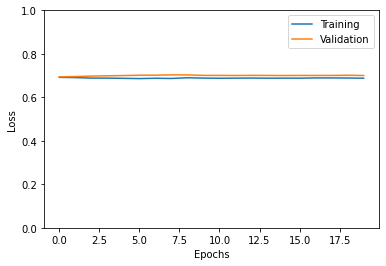

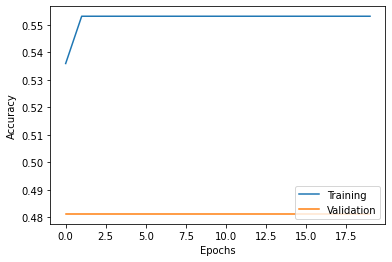

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline

def nn_hisotry(network_history):
    plt.figure()
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.plot(network_history.history['loss'])
    plt.plot(network_history.history['val_loss'])
    plt.legend(['Training', 'Validation'])
    plt.ylim((0, 1))

    plt.figure()
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.plot(network_history.history['accuracy'])
    plt.plot(network_history.history['val_accuracy'])
    plt.legend(['Training', 'Validation'], loc='lower right')
    plt.show()

nn_hisotry(nn_fs)

In [ ]:
table={'title':['Accurancy','Val_accurancy'],'value':[max(nn_fs.history['accuracy']),max(nn_fs.history['val_accuracy'])]}
pd.DataFrame(table)

,title,value
0,Accurancy,0.553125
1,Val_accurancy,0.481250


In [ ]:
predicted_classes = np.argmax(model.predict(data_test),axis=1)

# see which we predicted correctly and which not

correct_indices = np.nonzero(predicted_classes == y_test)[0]
incorrect_indices = np.nonzero(predicted_classes != y_test)[0]
print()
print(len(correct_indices)," classified correctly")
print(len(incorrect_indices)," classified incorrectly")
print(predicted_classes)
print(y_test)


102  classified correctly
98  classified incorrectly
[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
[0 0 0 0 1 1 1 0 1 1 0 1 0 0 1 1 1 0 0 0 1 1 1 0 0 0 0 0 1 0 1 0 1 0 1 1 1
 1 1 1 0 0 0 1 1 1 0 0 0 1 1 1 0 0 1 1 0 0 1 0 1 1 0 0 0 0 0 1 0 1 0 0 1 1
 1 1 0 1 1 1 1 1 1 0 1 1 0 0 1 0 0 0 0 1 1 1 0 1 1 1 1 0 0 1 0 0 0 1 1 1 1
 0 1 1 1 0 0 1 0 0 0 0 1 0 1 0 0 0 1 0 1 1 1 0 0 1 0 0 0 0 1 1 0 1 0 1 0 0
 0 0 1 1 1 0 1 0 0 0 1 1 1 1 0 1 1 0 1 1 0 0 1 1 1 1 0 1 1 1 0 0 1 1 0 0 0
 0 1 0 0 1 1 0 1 1 1 1 0 0 0 0]


In [ ]:
print(np.count_nonzero(y_train ==1))
print(np.count_nonzero(y_train ==0))

431
369
